<p align="center"><img src="https://raw.githubusercontent.com/IntelRealSense/librealsense/master/doc/img/realsense.png" width="70%" /></p>

## Introduction

The notebook offers a quick hands-on introduction to Intel RealSense Depth-Sensing technology. 

> **Have a Question?** [Open new issue on our GitHub](https://github.com/IntelRealSense/librealsense/issues/new)

## The Tools
We are planning to use the following packages:

In [35]:
import sys
# add path to jupyter notebook
sys.path.append("/usr/local/lib")
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt
import matplotlib.cm as cm      # 2D plotting library producing publication quality figures
import pyrealsense2 as rs    # Intel RealSense cross-platform open-source API
import traitlets,time,datetime
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import Robot

robot = Robot()

print("Environment Ready")

Environment Ready


## The API
Next, we will open depth and RGB streams from pre-recorded file and capture a set of frames:


In [2]:
# Setup:

try:
    pipe = rs.pipeline()
    cfg = rs.config()
    # cfg.enable_device_from_file("../object_detection.bag")
    profile = pipe.start(cfg)

    # Skip 5 first frames to give the Auto-Exposure time to adjust
    for x in range(5):
      pipe.wait_for_frames()

    # Store next frameset for later processing:
    frameset = pipe.wait_for_frames()
    color_frame = frameset.get_color_frame()
    depth_frame = frameset.get_depth_frame()

finally:
    # Cleanup:
    pipe.stop()
    print("Frames Captured")

Frames Captured


## RGB Data
Let's start with accessing the color componnent of the frameset:

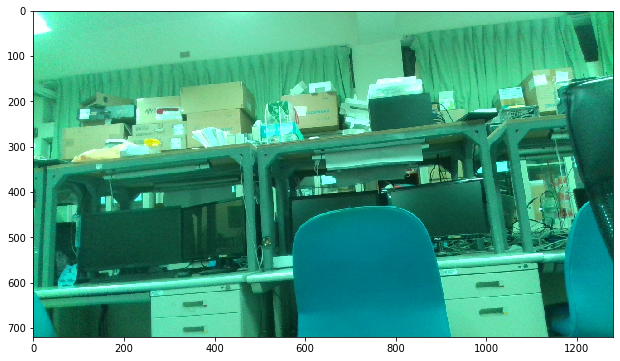

In [3]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

Now the two images are pixel-perfect aligned and you can use depth data just like you would any of the other channels.

## Object Detection

Next, we will take advantage of widely popular **MobileNet SSD Model** to recognize and localize objects in the scene and use additional depth data to enrich our prediction.

In [39]:

def detection_center(detection):
    """Computes the center x, y coordinates of the object"""
    bbox = detection
    center_x = (bbox[0] + bbox[2]) / 2.0 - 0.5
    center_y = (bbox[1] + bbox[3]) / 2.0 - 0.5
    return (center_x, center_y)
    
def norm(vec):
    """Computes the length of the 2D vector"""
    return np.sqrt(vec[0]**2 + vec[1]**2)

def closest_detection(detections):
    """Finds the detection closest to the image center"""
    closest_detection = None
    
    center = detection_center(detections)
    if closest_detection is None:
        closest_detection = detections
    elif norm(detection_center(detections)) < norm(detection_center(closest_detection)):
        closest_detection = detections
    return closest_detection

def obj_following(color):
    S_t= time.time()
    height, width = color.shape[:2]
    expected = 300
    aspect = width / height
    resized_image = cv2.resize(color, (round(expected * aspect), expected))
    crop_start = round(expected * (aspect - 1) / 2)
    crop_img = resized_image[0:expected, crop_start:crop_start+expected]

    net = cv2.dnn.readNetFromCaffe("../MobileNet-SSD/deploy.prototxt", "../MobileNet-SSD/mobilenet_iter_73000.caffemodel")
    inScaleFactor = 0.007843
    meanVal       = 127.53
    classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
                  "bottle", "bus", "car", "cat", "chair",
                  "cow", "diningtable", "dog", "horse",
                  "motorbike", "person", "pottedplant",
                  "sheep", "sofa", "train", "tvmonitor")

    blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
    net.setInput(blob, "data")
    detections = net.forward("detection_out")
#     print(detections)

    label = detections[0,0,0,1]
    conf  = detections[0,0,0,2]
    xmin  = detections[0,0,0,3]
    ymin  = detections[0,0,0,4]
    xmax  = detections[0,0,0,5]
    ymax  = detections[0,0,0,6]
    
    parms={
            "speed":0.15,
            "turn_gain":0.15
        }
    if 0 <= int(label) < 23 :
        target  = classNames[int(label)]
        
        cv2.rectangle(color, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
        cv2.putText(color, target, 
                    (int(xmin * expected), int(ymin * expected) - 5),
                    cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))
        now = datetime.datetime.now()
        cv2.imwrite('image/%s.jpg'%now.strftime("%Y%m%d_%H%M%S"), color, [cv2.IMWRITE_JPEG_QUALITY, 90])
        
        
    else:
        target = "Nothing"
        
        
    detections_ = {
        "bbox":[],
        "target":target
    }
    
    detections_["bbox"].append(xmin)
    detections_["bbox"].append(ymin)
    detections_["bbox"].append(xmax)
    detections_["bbox"].append(ymax)
    print(detections_)

    if detections_['target']=="person":
        bbox = detections_['bbox']
        det = bbox
        center = detection_center(det)

        if det is None:
            robot.forward(float(parms['speed']))

        # otherwsie steer towards target
        else:
            robot.set_motors(
                float(parms['speed']+ parms['turn_gain'] * center[0]),
                float(parms['speed'] - parms['turn_gain'] * center[0])
            )
            print("turn :",float(parms['speed']+ parms['turn_gain'] * center[0]),
                float(parms['speed'] - parms['turn_gain'] * center[0]))
    else:
        robot.forward(float(parms['speed']))
        
    E_t= time.time()
    print("Update time >>> ",E_t-S_t)
        
def get_np_frame(pipeline):
    try:
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        image = color_frame.get_data()
#         if not color_frame:
#             continue

        # Convert images to numpy arrays
        color_image = np.asanyarray(image)
        return color_image
    
    except Exception as e:
        print("[ERROR] Can't get the frame now")
        n = np.zeros((224,224))
        return n
    

# className = classNames[int(label)]

# cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
#              (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
# cv2.putText(crop_img, className, 
#             (int(xmin * expected), int(ymin * expected) - 5),
#             cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

# plt.imshow(crop_img)



In [40]:
def main():
    try:
    
        # Configure depth and color streams
        pipe = rs.pipeline()
        config = rs.config()
        # config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
        config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 60)
        pipe.start(config)

        for x in range(5):
          pipe.wait_for_frames()
        
        print("initializaiton...")
        
        while True:
            
            x = get_np_frame(pipe) #np_array in frame
            obj_following(x)
            
#     except Exception as e:
#         print("[ERROR] %s"%e)
        
    finally:
    
        pipe.stop()
        robot.stop()
    # Configure depth and color streams
    

    
main()

initializaiton...
{'bbox': [0.2679773, 0.09390533, 0.9886773, 0.9929435], 'target': 'person'}
turn : 0.1692490965127945 0.1307509034872055
Update time >>>  0.434185266494751
{'bbox': [0.041815966, 0.088077545, 0.9847233, 0.99214923], 'target': 'person'}
turn : 0.15199044942855836 0.14800955057144163
Update time >>>  0.35786914825439453
{'bbox': [0.1684061, 0.082576066, 0.99387944, 0.99311733], 'target': 'chair'}
Update time >>>  0.3434481620788574
{'bbox': [0.6057305, -0.0013073608, 0.8840392, 0.13042927], 'target': 'chair'}
Update time >>>  0.3551065921783447
{'bbox': [0.14310268, 0.016313165, 0.9971744, 1.0020264], 'target': 'person'}
turn : 0.1605207771062851 0.1394792228937149
Update time >>>  0.4636836051940918
{'bbox': [0.17962414, 0.010797709, 0.98924476, 0.9966291], 'target': 'chair'}
Update time >>>  0.35378241539001465
{'bbox': [0.010685474, 0.009378374, 0.9912181, 0.9982274], 'target': 'chair'}
Update time >>>  0.3418598175048828
{'bbox': [0.115997344, 0.001593709, 0.9917835

KeyboardInterrupt: 

In [27]:
robot.stop()

In [24]:
# def following(detections):

# draw all detections on image
bbox = detections_['bbox']
# cv2.rectangle(image, (int(width * bbox[0]), int(height * bbox[1])), (int(width * bbox[2]), int(height * bbox[3])), (255, 0, 0), 2)

# select detections that match selected class label
det = bbox

# get detection closest to center of field of view and draw it
# det = closest_detection(matching_detections)
# if det is not None:
#     bbox = det['bbox']
#     cv2.rectangle(image, (int(width * bbox[0]), int(height * bbox[1])), (int(width * bbox[2]), int(height * bbox[3])), (0, 255, 0), 5)

parms={
    "speed":0.2,
    "turn_gain":0.5
}

center = detection_center(det)
print(center)


# otherwise go forward if no target detected
if det is None:
    robot.forward(float(parms['speed']))

# otherwsie steer towards target
else:
    # move robot forward and steer proportional target's x-distance from center
    
#     robot.set_motors(
#         float(speed_widget.value + turn_gain_widget.value * center[0]),
#         float(speed_widget.value - turn_gain_widget.value * center[0])
#     )
    robot.set_motors(
        float(parms['speed']+ parms['turn_gain'] * center[0]),
        float(parms['speed'] - parms['turn_gain'] * center[0])
    )

(0.08062982559204102, 0.26719778776168823)


In [9]:
robot.stop()

By projecting this data into the depth channel, we can now answer additional questions we couldn't approach before.

For example, with computer vision only it would be rather hard to make any meaningful predictions about **size and distance**.
You could train a model on average dog size per breed, but it would be easily fooled by toys of dogs or dogs of irregular proportions. Instead you can get this information directly when you have depth available!

Let's project our detected bounding box on to the depth image, and average the depth data inside it to get a sense of how close is the object:

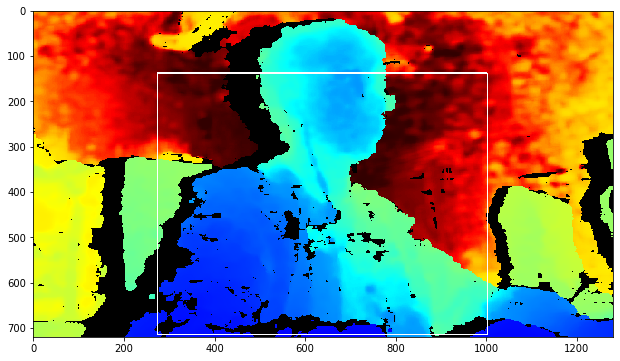

In [10]:
scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [12]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)
# print("depth :",depth)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
# min_=99999999999999
# max_=0
# for rows in depth:
#     if max(rows)>max_:
#         max_ = max(rows)
#     if min(rows)<min_ and min(rows)!=0:
#         min_ = min(rows)
# print("Farest distance:",max_)
# print("Nearset distance:",min_)
        

dist,_,_,_ = cv2.mean(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))

Detected a chair 0.845 meters away.


This is a rather simple example, but it gives you a taste of what can be accomplished by combining depth with modern computer vision.

> **Want to learn more?** Visit [realsense.intel.com](http://realsense.intel.com) and [github.com/IntelRealSense](http://www.github.com/IntelRealSense/librealsense)